In [3]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

In [4]:
losses = torch.load('models/model_21-01-2024-23-21-56_losses.pt')
print(losses)

[362163843.4329502, 330537934.9578544, 583022474.2988505, 578275300.5363984, 407476710.4980843, 650959146.1762452, 384917374.52873564, 566272023.5402299, 324287616.4904215, 510537963.40229887, 310801253.51724136, 393214952.45977014, 387244624.42911875, 461674346.9118774, 590957187.4329501, 547284576.1226053, 375648432.55172414, 428113606.1302682, 338706282.9118774, 391623193.5019157, 455664259.4329502, 466799604.22988504, 368530630.1302682, 326431651.8007663, 615105398.6819923, 382473553.4099617, 520116914.51341, 510092770.57471263, 450243446.68199235, 356691261.79310346, 451833432.2758621, 394998603.5249042, 367457048.5210728, 379201724.3218391, 328418639.44827586, 339325106.51341, 653775538.51341, 385926493.1800766, 496668420.90421456, 338466168.6436782, 365217085.79310346, 279358543.44827586, 446683426.3295019, 384982282.789272, 562378712.7662835, 443104197.14942527, 378986417.532567, 570529383.9693487, 405098582.31417626, 331558358.8045977, 404289539.9233717, 335046748.1992337, 344

Text(0, 0.5, 'Loss (Average MSE)')

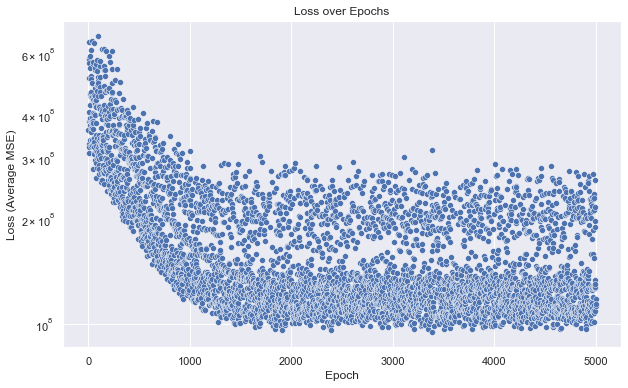

In [6]:
ax = sns.scatterplot(losses)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.set_ylabel('Loss (Average MSE)')


In [7]:
# Setup Model
from model import GCN

model = GCN()
model.state_dict = torch.load('models/model_21-01-2024-23-21-56.pt')
model.eval()


GCN(
  (relu): ReLU()
  (conv1): GCNConv(2, 32)
  (conv2): GCNConv(32, 128)
  (conv3): GCNConv(128, 128)
  (conv4): GCNConv(128, 128)
  (conv5): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=1, bias=True)
  (leaky): LeakyReLU(negative_slope=0.01)
)

In [8]:
data = torch.load("datasets/SG256_From_Enzo_Cleaned_SM_Only_Train.pt")

y_truth = []
y_pred = []
for graph in data:
    # Feature Selection (should do this better...)
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])

    for item in graph.y:
        y_truth.append(item.item())

    out = model(graph)
    for item in out.tolist():
        y_pred.append(item[0])

print(len(y_pred), len(y_truth))
print(y_pred, y_truth)


10985 10985
[4705.03564453125, 3579.686279296875, 2570.84423828125, 3335.028076171875, 135870.359375, 672301.625, 142140.5625, 4118.4482421875, 5733.0830078125, 5250.36669921875, 4216.9052734375, 3084.16015625, 2398.46142578125, 2106.24267578125, 3817.525146484375, 4349.275390625, 137744.75, 205866.71875, 140060.5625, 137134.40625, 206538.28125, 137772.28125, 26515.150390625, 152368.25, 148468.234375, 139921.890625, 135678.40625, 141724.609375, 136302.328125, 137148.359375, 172031.484375, 110660.0625, 203483.21875, 229643.84375, 35699.24609375, 133390.3125, 1286.4461669921875, 6096.0498046875, 130284.1015625, 134166.828125, 166093.546875, 181690.125, 128106.9140625, 175702.390625, 134610.59375, 101426.9609375, 160929.25, 127288.59375, 178764.8125, 124834.125, 124168.4609375, 143993.625, 11825.416015625, 8295.306640625, 12143.01953125, 12409.2744140625, 12381.623046875, 12634.5673828125, 13494.091796875, 14441.267578125, 14878.65625, 14219.53125, 13053.853515625, 13392.482421875, 15545.

Text(0, 0.5, 'Predicted Stellar Mass (MSun)')

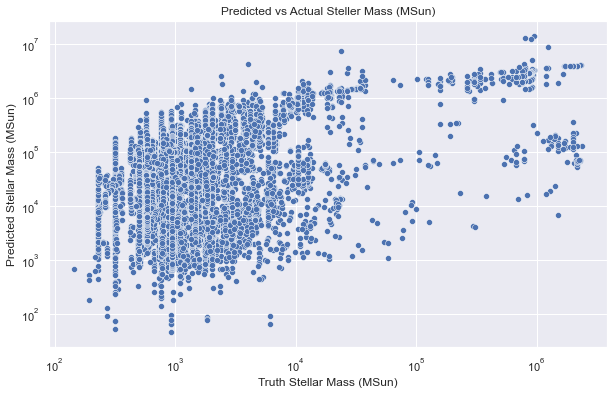

In [9]:
ax = sns.scatterplot(x=y_truth, y=y_pred)
ax.set_title('Predicted vs Actual Steller Mass (MSun)')
ax.set_xscale('log')
ax.set_xlabel('Truth Stellar Mass (MSun)')
ax.set_yscale('log')
ax.set_ylabel('Predicted Stellar Mass (MSun)')